# TensorFlow 2 and Keras quickstart for geospatial computer vision

This short introduction uses [Keras](https://www.tensorflow.org/guide/keras/overview) to:

1. Load a prebuilt geospatial dataset (two options).
1. Build a neural network machine learning model that classifies images.
2. Train this neural network.
3. Evaluate the accuracy of the model.

In [1]:
# install required libraries
!pip install -q rasterio
!pip install -q geopandas
!pip install -q radiant_mlhub # for dataset access, see: https://mlhub.earth/

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 52.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.1/52.1 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 32.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.4/137.4 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 33.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 6.1 MB/s eta 0:00:00


In [22]:
import os, glob, functools, fnmatch, io, shutil, tarfile, json
from zipfile import ZipFile
from itertools import product
from pathlib import Path
import urllib.request
from radiant_mlhub import Dataset, client, get_session, Collection
import pandas as pd
from sklearn.model_selection import train_test_split
from PIL import Image
import numpy as np
from google.colab import drive
import tensorflow_datasets as tfds
from tensorflow.keras.utils import plot_model
from matplotlib import pyplot

## Set up TensorFlow

Import TensorFlow into your program to get started:

In [3]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.12.0


In [4]:
# Mount google drive.
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
# set your root directory and tiled data folders
if 'google.colab' in str(get_ipython()):
    # mount google drive
    drive.mount('/content/gdrive')
    root_dir = '/content/gdrive/My Drive/tf-eo-devseed-2/'
    workshop_dir = '/content/gdrive/My Drive/tf-eo-devseed-workshop-2'
    dirs = [root_dir, workshop_dir]
    for d in dirs:
        if not os.path.exists(d):
            os.makedirs(d)
    print('Running on Colab')
else:
    root_dir = os.path.abspath("./data/tf-eo-devseed-2")
    workshop_dir = os.path.abspath('./tf-eo-devseed-workshop-2')
    print(f'Not running on Colab, data needs to be downloaded locally at {os.path.abspath(root_dir)}')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Running on Colab


In [6]:
%cd $root_dir

/content/gdrive/My Drive/tf-eo-devseed-2


## Let's use a dataset from TF Datasets

We will use the Eurosat dataset, which contains labeled Sentinel-2 image patches classified into 10 land cover types. More details here: https://www.tensorflow.org/datasets/catalog/eurosat

In [7]:
def get_train_test_splits(dataset, image_arrays_list, label_integers_list):
  """
  Function to get dataset splits for training and testing.
  """
  for features in train_dataset.take(len(train_dataset)):
    image, label = features["image"], features["label"]
    image_arrays_list.append(image)
    label_integers_list.append(label)
  x_dataset, y_dataset = np.array(image_arrays_list), np.array(label_integers_list)
  return x_dataset, y_dataset


In [8]:
# Construct tf.data.Dataset(s)
all_dataset = tfds.load(name="eurosat", split=tfds.Split.TRAIN)
all_dataset = all_dataset.shuffle(1024)
test_dataset = all_dataset.take(int(len(all_dataset)*0.3))
train_dataset = all_dataset.skip(int(len(all_dataset)*0.3))

train_image_arrays = []
train_label_integers = []
test_image_arrays = []
test_label_integers = []

x_train, y_train = get_train_test_splits(train_dataset, train_image_arrays, train_label_integers)
x_test, y_test = get_train_test_splits(test_dataset, test_image_arrays, test_label_integers)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Shuffling /root/tensorflow_datasets/eurosat/rgb/2.0.0.incomplete5ORZVA/eurosat-train.tfrecord*...:   0%|      …

Dataset eurosat downloaded and prepared to /root/tensorflow_datasets/eurosat/rgb/2.0.0. Subsequent calls will reuse this data.


In [ ]:
# Check for all classes in each split
# set(train_label_integers), set(test_label_integers)

In [9]:
# Dataset specific parameters to be used in the model structure
input_shape=(64, 64, 3)
num_classes = 10

## Now, let's build a very basic machine learning model

We'll use the `tf.keras.Sequential` model structure:

In [25]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=input_shape),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(num_classes)
])

The [`Sequential`](https://www.tensorflow.org/guide/keras/sequential_model) structure is designed to stack layers where each layer has an input [a tensor](https://www.tensorflow.org/guide/tensor) and an output tensor. Layers themselves are simply functions performing matrix calculations. They may contain trainable variables and are reusable.

It is most common for TensorFlow models to be composed of layers. This sequential model is composed of the [`Flatten`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Flatten), [`Dense`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense), and [`Dropout`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout) layers.

For each data sample provided the model, the corresponding output is a vector of [logits](https://developers.google.com/machine-learning/glossary#logits) or [log-odds](https://developers.google.com/machine-learning/glossary#log-odds) scores, for each class.

In [26]:
predictions = model(x_train[:1]).numpy()
predictions

array([[-137.11224  ,   67.67007  ,   -9.194836 ,  -62.869877 ,
          -1.0573664,   56.408875 ,  -30.047808 ,   -4.9318237,
         148.80371  ,  -31.821905 ]], dtype=float32)

The `tf.nn.softmax` function converts logits to *probabilities* for each class:

In [27]:
tf.nn.softmax(predictions).numpy()

array([[0.0000000e+00, 5.8090626e-36, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        1.0000000e+00, 0.0000000e+00]], dtype=float32)

The next step is to specify a loss function for training. We will be using `losses.SparseCategoricalCrossentropy` as it is a commonly used loss function for multi-class data:

In [28]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

The input to the loss function is a vector of ground truth values and a vector of logits. The returned output is a scalar loss for each data sample. Loss values close to zero are good, as they imply proximity to the correct class.

The untrained model will produce probabilities close to random (1/n for each class), so the initial loss should be close to `-tf.math.log(1/n)`.

In [29]:
loss_fn(y_train[:1], predictions).numpy()

81.133644

Before the model can be trained, it needs to be configured and compiled, using Keras `Model.compile`. In this step, we establish the [`optimizer`](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers) class (which in this case will be `adam`), the `loss` to the `loss_fn` function defined earlier, and a metric that will be used evaluate the model at each iteration (herein we will use `accuracy`).

In [30]:
lr = 0.001 # learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=lr) # optimizer

In [31]:
model.compile(optimizer=optimizer,
              loss=loss_fn,
              metrics=['accuracy'])

In [32]:
# Summarize the model
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 12288)             0         
                                                                 
 dense_2 (Dense)             (None, 128)               1572992   
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 10)                1290      
                                                                 
Total params: 1,574,282
Trainable params: 1,574,282
Non-trainable params: 0
_________________________________________________________________


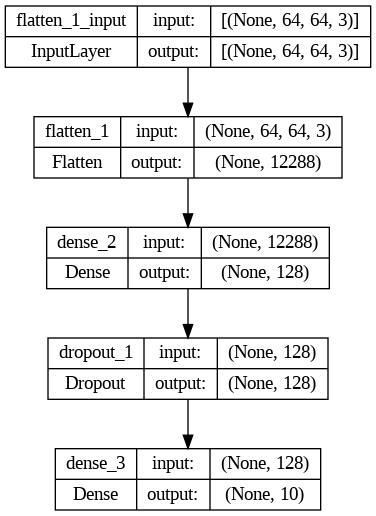

In [33]:
# Visualize the model
plot_model(model, show_shapes=True)

## Train and evaluate your model

No we will train the model using the `Model.fit` Keras method. During the following iterations, the model parameters will adjust and we will hope to see the loss.

In [36]:
# We will save the model fit history as an object to subsequently get attributes from (e.g. loss curves).
# This is an optional measure.
history = model.fit(x_train, y_train, validation_data= (x_test, y_test), epochs=10)

Epoch 1/10
591/591 [==============================] - 16s 28ms/step - loss: 2.2964 - accuracy: 0.1115 - val_loss: 2.2962 - val_accuracy: 0.1116
Epoch 2/10
591/591 [==============================] - 16s 27ms/step - loss: 2.2964 - accuracy: 0.1110 - val_loss: 2.2962 - val_accuracy: 0.1116
Epoch 3/10
591/591 [==============================] - 16s 27ms/step - loss: 2.2964 - accuracy: 0.1106 - val_loss: 2.2962 - val_accuracy: 0.1116
Epoch 4/10
591/591 [==============================] - 16s 27ms/step - loss: 2.2964 - accuracy: 0.1115 - val_loss: 2.2962 - val_accuracy: 0.1116
Epoch 5/10
591/591 [==============================] - 16s 27ms/step - loss: 2.2964 - accuracy: 0.1121 - val_loss: 2.2962 - val_accuracy: 0.1116
Epoch 6/10
591/591 [==============================] - 16s 27ms/step - loss: 2.2964 - accuracy: 0.1111 - val_loss: 2.2962 - val_accuracy: 0.1116
Epoch 7/10
591/591 [==============================] - 16s 27ms/step - loss: 2.2965 - accuracy: 0.1113 - val_loss: 2.2962 - val_accuracy:

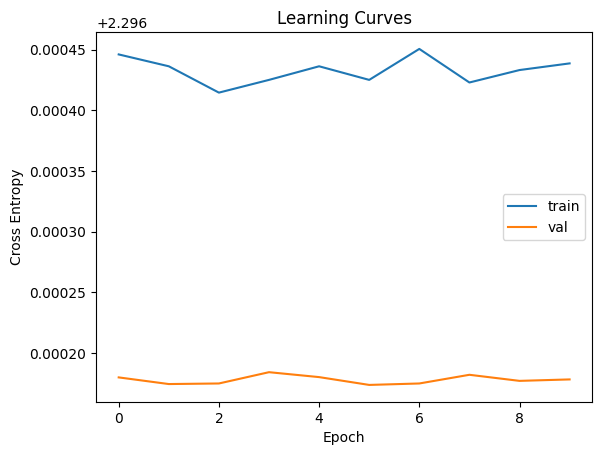

In [37]:
# plot learning curves
pyplot.title('Learning Curves')
pyplot.xlabel('Epoch')
pyplot.ylabel('Cross Entropy')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='val')
pyplot.legend()
pyplot.show()

To evaluate the mode, we will use the `Model.evaluate` Keras method. The performance is evaluated on a [test set](https://developers.google.com/machine-learning/glossary#test-set).

In [38]:
model.evaluate(x_test,  y_test, verbose=2)

591/591 - 2s - loss: 2.2962 - accuracy: 0.1116 - 2s/epoch - 4ms/step


[2.2961783409118652, 0.11164021492004395]

We can return probabilities for the predictions by attaching a softmax to the trained model.

In [39]:
probability_model = tf.keras.Sequential([
  model,
  tf.keras.layers.Softmax()
])

In [40]:
probability_model(x_test[:5])

<tf.Tensor: shape=(5, 10), dtype=float32, numpy=
array([[0.10791875, 0.11046039, 0.10993448, 0.09152905, 0.09366088,
        0.07742317, 0.09347883, 0.11273941, 0.09235851, 0.11049651],
       [0.10791875, 0.11046039, 0.10993448, 0.09152905, 0.09366088,
        0.07742317, 0.09347883, 0.11273941, 0.09235851, 0.11049651],
       [0.10791875, 0.11046039, 0.10993448, 0.09152905, 0.09366088,
        0.07742317, 0.09347883, 0.11273941, 0.09235851, 0.11049651],
       [0.10791875, 0.11046039, 0.10993448, 0.09152905, 0.09366088,
        0.07742317, 0.09347883, 0.11273941, 0.09235851, 0.11049651],
       [0.10791875, 0.11046039, 0.10993448, 0.09152905, 0.09366088,
        0.07742317, 0.09347883, 0.11273941, 0.09235851, 0.11049651]],
      dtype=float32)>

## Load a dataset, part 2 (option 2)

Load and prepare the [Drone Imagery Classification Training Dataset for Crop Types in Rwanda dataset from Radiant Earth](https://mlhub.earth/data/rti_rwanda_crop_type). You'll need a Radiant Earth MLHub API key for this.

In [ ]:
# configure Radiant Earth MLHub access
!mlhub configure

In [ ]:
ds = Dataset.fetch('rti_rwanda_crop_type')
for c in ds.collections:
    print(c.id)


rti_rwanda_crop_type_labels
rti_rwanda_crop_type_source
rti_rwanda_crop_type_raw


In [ ]:
collections = [
    'rti_rwanda_crop_type_labels',
    'rti_rwanda_crop_type_source'
]

def download(collection_id):
    print(f'Downloading {collection_id}...')
    collection = Collection.fetch(collection_id)
    path = collection.download('.')
    tar = tarfile.open(path, "r:gz")
    tar.extractall()
    tar.close()
    os.remove(path)

def resolve_path(base, path):
    return Path(os.path.join(base, path)).resolve()

def load_df(collection_id):
    collection = json.load(open(f'{collection_id}/collection.json', 'r'))
    rows = []
    item_links = []
    for link in collection['links']:
        if link['rel'] != 'item':
            continue
        item_links.append(link['href'])
    for item_link in item_links:
        item_path = f'{collection_id}/{item_link}'
        current_path = os.path.dirname(item_path)
        item = json.load(open(item_path, 'r'))
        tile_id = item['id'].split('_')[-1]
        for asset_key, asset in item['assets'].items():
            rows.append([
                tile_id,
                None,
                None,
                asset_key,
                str(resolve_path(current_path, asset['href']))
            ])

        for link in item['links']:
            if link['rel'] != 'source':
                continue
            link_path = resolve_path(current_path, link['href'])
            source_path = os.path.dirname(link_path)
            try:
                source_item = json.load(open(link_path, 'r'))
            except FileNotFoundError:
                continue
            datetime = source_item['properties']['datetime']
            satellite_platform = source_item['collection'].split('_')[-1]
            for asset_key, asset in source_item['assets'].items():
                rows.append([
                    tile_id,
                    datetime,
                    satellite_platform,
                    asset_key,
                    str(resolve_path(source_path, asset['href']))
                ])
    return pd.DataFrame(rows, columns=['tile_id', 'datetime', 'satellite_platform', 'asset', 'file_path'])

for c in collections:
    download(c)

train_df = load_df('rti_rwanda_crop_type_labels')
#test_df = load_df('rti_rwanda_crop_type_labels')

  0%|          | 0/0.8 [00:00<?, ?M/s]

  0%|          | 0/104.5 [00:00<?, ?M/s]

In [ ]:
# Read the classes
pd.set_option('display.max_colwidth', None)

data = {'class_names':  ['other', 'banana', 'maize', 'legumes', 'forest', 'structure'],
        'class_ids': [0, 1, 2, 3, 4, 5]
        }

classes = pd.DataFrame(data)
print(classes)

classes.to_csv('rti_rwanda_crop_type_classes.csv')

  class_names  class_ids
0       other          0
1      banana          1
2       maize          2
3     legumes          3
4      forest          4
5   structure          5


In [ ]:
train_df_labels = train_df.loc[train_df['asset'] == 'labels']

In [ ]:
data_train, data_test = train_test_split(train_df_labels, test_size=0.3, random_state=1)

In [ ]:
len(data_train), len(data_test)

(1824, 782)

In [ ]:
def get_RE_train_test(dataset, image_array_list, label_integer_list):
  for i, r in data_train.iterrows():
    label_path = r.file_path
    with open(label_path) as f:
      label_obj = json.load(f)
    label_str = label_obj['label']
    label_int = classes.loc[classes['class_names'] == label_str, 'class_ids'].squeeze()
    label_integer_list.append(label_int)
    image_path = label_path.replace('labels', 'source')
    image_path = image_path.replace('source.json', '')
    image_obj = np.array(Image.open(f"{image_path}/image.png"))
    image_array_list.append(image_obj)
  return image_array_list, label_integer_list

In [ ]:
train_image_arrays = []
train_label_integers = []

train_image_arrays, train_label_integers = get_RE_train_test(data_train, train_image_arrays, train_label_integers)

In [ ]:
test_image_arrays = []
test_label_integers = []

test_image_arrays, test_label_integers = get_RE_train_test(data_test, test_image_arrays, test_label_integers)

In [ ]:
set(train_label_integers), set(test_label_integers)

({0, 1, 2, 3, 4, 5}, {0, 1, 2, 3, 4, 5})

In [ ]:
x_train, y_train = np.array(train_image_arrays), np.array(train_label_integers)
x_test, y_test = np.array(test_image_arrays), np.array(test_label_integers)

In [ ]:
input_shape = (200, 200, 3)
num_classes = 6

In [ ]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=input_shape),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(num_classes)
])

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

model.compile(optimizer='adam',
              loss=loss_fn,
              metrics=['accuracy'])

In [ ]:
model.fit(x_train, y_train, epochs=5)

In [ ]:
model.evaluate(x_test,  y_test, verbose=2)

In [ ]:
probability_model = tf.keras.Sequential([
  model,
  tf.keras.layers.Softmax()
])

In [ ]:
probability_model(x_test[:5])